In [2]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Reproducibility
tf.keras.utils.set_random_seed(42)
np.random.seed(42)

In [3]:
# Load dataset
df = pd.read_csv("creditcard.csv")
display(df.head())
print("Shape: ", df.shape)
print("Columns: ", df.columns.tolist())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Shape:  (284807, 31)
Columns:  ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [5]:
# Build features X and labels y
X = df.drop(columns=["Time", "Class"]).astype("float32").values
y = df["Class"].astype("int32").values

print("X shape: ", X.shape)
print("y distribution:\n", pd.Series(y).value_counts(normalize=True))

X shape:  (284807, 29)
y distribution:
 0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [6]:
# Train/Test split, isolate normals for autoencoder training
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Keep only normals (Class==0) for AE training
X_train_norm = X_train_all[y_train_all==0]

print("All-train shape: ", X_train_all.shape)
print("All-test shape: ", X_test_all.shape)
print("Normal-train shape (for AE): ", X_train_norm.shape)

All-train shape:  (227845, 29)
All-test shape:  (56962, 29)
Normal-train shape (for AE):  (227451, 29)


In [7]:
# Normal train/validation split
Xn_train, Xn_val = train_test_split(
    X_train_norm, test_size=0.2, random_state=42
)

print("Xn_train: ", Xn_train.shape, "| Xn_val: ", Xn_val.shape)

Xn_train:  (181960, 29) | Xn_val:  (45491, 29)


In [8]:
# Scaling (fit on normal-train only)
scaler = StandardScaler().fit(Xn_train) # fit on normals only
Xn_train_s = scaler.transform(Xn_train)
Xn_val_s = scaler.transform(Xn_val)
X_test_s = scaler.transform(X_test_all) # full test (normals + fraud)
y_test = y_test_all.copy() # final ground truth for evaluation

print("Scaled shapes: ", Xn_train_s.shape, Xn_val_s.shape, X_test_s.shape)

Scaled shapes:  (181960, 29) (45491, 29) (56962, 29)


In [9]:
# Autoencoder
INPUT_DIM = Xn_train_s.shape[1]
INTERMEDIATE_DIM = 24
LATENT_DIM = 14

inp = Input(shape=(INPUT_DIM, ), name="Input")
e = Dense(INTERMEDIATE_DIM, activation="relu", name="Encoder_L1")(inp)
latent = Dense(LATENT_DIM, activation="relu", name="Latent")(e)
d = Dense(INTERMEDIATE_DIM, activation="relu", name="Decoder_L1")(latent)
out = Dense(INPUT_DIM, activation="linear", name="Reconstruction")(d)

autoencoder = Model(inputs=inp, outputs=out, name="Autoencoder")
autoencoder.summary()

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 29)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_L1 (Dense)                   │ (None, 24)                  │             720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Latent (Dense)                       │ (None, 14)                  │             350 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_L1 (Dense)                   │ (None, 24)                  │             360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Reconstruction (Dense)               │ (None, 29)                  │             725 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,155 (8.42 KB)

 Trainable params: 2,155 (8.42 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Compile and Train
autoencoder.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mse"]
)

EPOCHS = 20
BATCH = 128

history = autoencoder.fit(
    Xn_train_s, Xn_train_s,
    validation_data=(Xn_val_s, Xn_val_s),
    epochs=EPOCHS,
    batch_size=BATCH,
    shuffle=True,
    verbose=2
)

Epoch 1/20
1422/1422 - 4s - 3ms/step - loss: 0.5642 - mse: 0.5642 - val_loss: 0.4001 - val_mse: 0.4001
Epoch 2/20
1422/1422 - 3s - 2ms/step - loss: 0.3518 - mse: 0.3518 - val_loss: 0.3203 - val_mse: 0.3203
Epoch 3/20
1422/1422 - 3s - 2ms/step - loss: 0.3008 - mse: 0.3008 - val_loss: 0.2868 - val_mse: 0.2868
Epoch 4/20
1422/1422 - 3s - 2ms/step - loss: 0.2744 - mse: 0.2744 - val_loss: 0.2668 - val_mse: 0.2668
Epoch 5/20
1422/1422 - 3s - 2ms/step - loss: 0.2595 - mse: 0.2595 - val_loss: 0.2531 - val_mse: 0.2531
Epoch 6/20
1422/1422 - 3s - 2ms/step - loss: 0.2437 - mse: 0.2437 - val_loss: 0.2288 - val_mse: 0.2288
Epoch 7/20
1422/1422 - 3s - 2ms/step - loss: 0.2272 - mse: 0.2272 - val_loss: 0.2165 - val_mse: 0.2165
Epoch 8/20
1422/1422 - 3s - 2ms/step - loss: 0.2209 - mse: 0.2209 - val_loss: 0.2113 - val_mse: 0.2113
Epoch 9/20
1422/1422 - 3s - 2ms/step - loss: 0.2183 - mse: 0.2183 - val_loss: 0.2088 - val_mse: 0.2088
Epoch 10/20
1422/1422 - 3s - 2ms/step - loss: 0.2157 - mse: 0.2157 - val_

In [11]:
# Reconstruction error 
def recon_error(model, data):
    recon = model.predict(data, verbose=2)
    return np.mean(np.square(data - recon), axis=1)

err_val_norm = recon_error(autoencoder, Xn_val_s) # errors on unseen normals
err_test = recon_error(autoencoder, X_test_s) # errors on full test set

1422/1422 - 1s - 904us/step
1781/1781 - 1s - 822us/step


In [12]:
# Threshold selection and predictions
threshold = np.percentile(err_val_norm, 95)
print("Threshold (95th percentile of normal-val errors): ", threshold)

y_pred = (err_test > threshold).astype(int) # 1 = anomaly
y_true = y_test # ground-truth: 1=fraud

Threshold (95th percentile of normal-val errors):  0.4752924293279648


In [13]:
# Evaluation metrics
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
auc = roc_auc_score(y_true, err_test)
cm = confusion_matrix(y_true, y_pred)

print(f"Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}  ROC-AUC: {auc:.4f}")
print("Confusion Matrix:\n", cm)

Precision: 0.0282  Recall: 0.8571  F1: 0.0546  ROC-AUC: 0.9341
Confusion Matrix:
 [[53971  2893]
 [   14    84]]


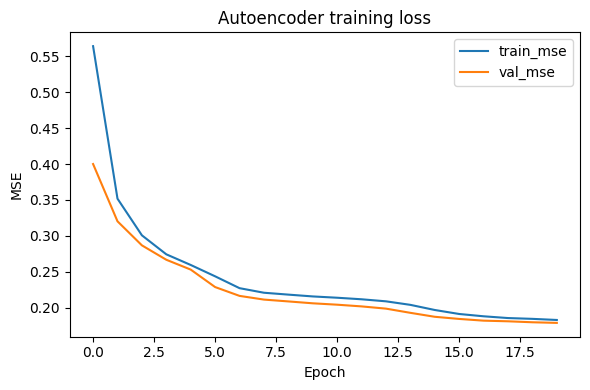

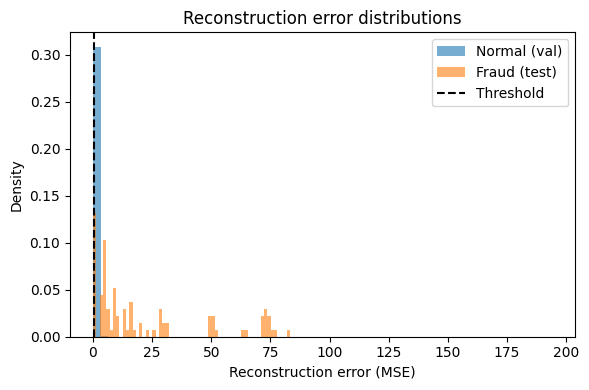

In [16]:
# plot training loss
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train_mse")
plt.plot(history.history["val_loss"], label="val_mse")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title("Autoencoder training loss")
plt.legend(); plt.tight_layout(); plt.show()

# error histogram (density)
err_test_norm = err_test[y_true == 0]
err_test_fraud = err_test[y_true == 1]

plt.figure(figsize=(6,4))
plt.hist(err_val_norm, bins=60, alpha=0.6, density=True, label="Normal (val)")
plt.hist(err_test_fraud, bins=60, alpha=0.6, density=True, label="Fraud (test)")
plt.axvline(threshold, color="k", linestyle="--", label="Threshold")
plt.xlabel("Reconstruction error (MSE)"); plt.ylabel("Density")
plt.title("Reconstruction error distributions")
plt.legend(); plt.tight_layout(); plt.show()